This is the same as the notebook *book_rank_OLS.ipynb*, but now we will perform the additional steps of solving the book rank problem using Maximum Likelihood Estimation. 

Import the libraries you are going to use. In most cases, we will use these libraries.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats

Specify the location from where you loading your file.

In [2]:
data_in = pd.read_excel('book_rank_data.xlsx')
data = data_in.copy()
data.head()

,DATE,ISBN,Title,Weekly Sales,Weekly Average Rank
0,37002.0,'0596000405,Java Servlet Programming (2nd Edition),227,238.0
1,37002.0,'0596000278,Java Servlet Programming (2nd Edition),269,258.0
2,37002.0,'1565922840,Programming Perl (3rd Edition),135,388.0
3,37002.0,'1565923928,Developing Bioinformatics Computer Skills,481,401.5
4,37002.0,'1565924274,Programming Perl (3rd Edition),145,408.0


Convert into Log forms.

In [3]:
data['Lnrank'] = np.log(data['Weekly Average Rank'])
data['Lnsales'] = np.log(data['Weekly Sales'])
data.head()

,DATE,ISBN,Title,Weekly Sales,Weekly Average Rank,Lnrank,Lnsales
0,37002.0,'0596000405,Java Servlet Programming (2nd Edition),227,238.0,5.472271,5.424950
1,37002.0,'0596000278,Java Servlet Programming (2nd Edition),269,258.0,5.552960,5.594711
2,37002.0,'1565922840,Programming Perl (3rd Edition),135,388.0,5.961005,4.905275
3,37002.0,'1565923928,Developing Bioinformatics Computer Skills,481,401.5,5.995208,6.175867
4,37002.0,'1565924274,Programming Perl (3rd Edition),145,408.0,6.011267,4.976734


plot the log of sales and rank

<AxesSubplot:xlabel='Lnrank', ylabel='Lnsales'>

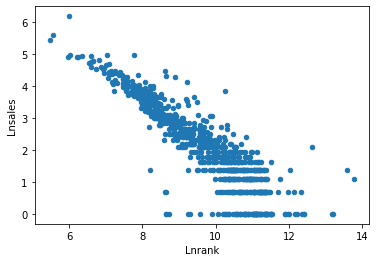

In [4]:
data.plot('Lnrank', 'Lnsales', 'scatter')

plot the histogram

array([[<AxesSubplot:title={'center':'Weekly Sales'}>]], dtype=object)

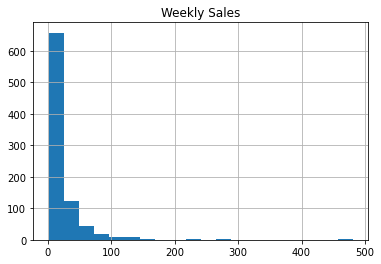

In [5]:
data.hist('Weekly Sales', bins=20)

Run an OLS with Lnsales (Y) as dependent variable and Lnrank (X) as independent variable. We have to make sure we specify the intercept.We do that create adding column on constant to our independent variable X.

In [6]:
X = data.Lnrank
Y = data.Lnsales
X = sm.add_constant(X)
results = sm.OLS(Y,X).fit()

C:\Users\rston\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [7]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Lnsales   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     3454.
Date:                Mon, 21 Oct 2024   Prob (F-statistic):          3.03e-303
Time:                        22:50:26   Log-Likelihood:                -738.13
No. Observations:                 861   AIC:                             1480.
Df Residuals:                     859   BIC:                             1490.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.5260      0.143     73.374      0.000      10.244      10.808
Lnrank        -0.8712      0.015    -58.774      0.000      -0.900      -0.842
==============================================================================
Omnibus:                      176.859   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1142.401
Skew:                          -0.762   Prob(JB):                    8.53e-249
Kurtosis:                       8.433   Cond. No.                         72.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# MLE Solution:

In Python, we can directly calculate the log value of the normal distribution using the function norm.logpdf(). So we use it and sum the values.

In [8]:
from scipy.stats import norm
from scipy.optimize import minimize

In [9]:
# Define Log Likelihood
def MLE_Norm(parameters):
    # Extract parameters.
    const, beta, std_dev = parameters
    # Regression equation.
    pred = const + beta * data.Lnrank

    # Calculate the log likelihood for the normal distribution of pred
    LL = norm.logpdf(data.Lnsales, pred, std_dev).sum()
    neg_LL = -1 * LL
    return neg_LL

We now use the minimize function with appropriate attributes to calculate the value of parameters that will maximize the function. The parameters here are "logrank", "constant", and "standard deviation" of the normal distribution. We again use Nelder-mead as the minimization method. We also use other methods like "SLSQP".

In [10]:
mle_model = minimize(MLE_Norm, [0.3, 0.3, 1], method="Nelder-mead", options={'disp': True})
print(mle_model)

Optimization terminated successfully.
         Current function value: 738.131722
         Iterations: 108
         Function evaluations: 198
 final_simplex: (array([[10.52605549, -0.87124735,  0.57026798],
       [10.52596828, -0.87123875,  0.57026738],
       [10.52603677, -0.87124471,  0.57027167],
       [10.52598049, -0.87123959,  0.57026452]]), array([738.13172202, 738.13172203, 738.13172209, 738.13172212]))
           fun: 738.1317220172209
       message: 'Optimization terminated successfully.'
          nfev: 198
           nit: 108
        status: 0
       success: True
             x: array([10.52605549, -0.87124735,  0.57026798])


Estimates are: intercept is 10.5, slope is -0.87, and standard deviation is 0.57.

Plotting the normal distribution with estimated parameters and data.

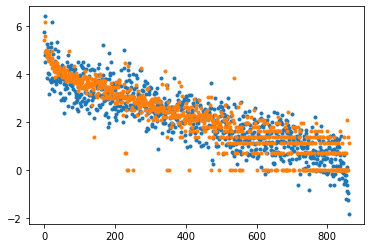

In [11]:
const = mle_model.x[0]
beta = mle_model.x[1]
sigma = mle_model.x[2]
pred = const + beta * data.Lnrank
plt.plot(np.random.normal(loc=pred, scale=sigma, size=None), '.')
plt.plot(data.Lnsales, '.')

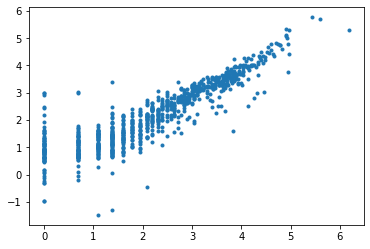

In [12]:
plt.plot(data.Lnsales, pred, '.')